# Exercise 1. Convolutional Autoencoder

In [0]:
import numpy as np
np.random.seed(1)
import torch
import torch.optim as optim
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
from IPython.display import display


## Load the MNIST datasets into DataLoaders

In [2]:
hparams = {
    'batch_size':64,
    'num_epochs':20,
    'val_batch_size':64,
    'test_batch_size':64,
    'learning_rate':1e-3
}

mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

length_train = len(mnist_trainset)

train_dataset, validation_dataset = torch.utils.data.random_split(mnist_trainset, [int(0.95*length_train), int(0.05*length_train)])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=True,drop_last=True) 

val_loader = torch.utils.data.DataLoader(validation_dataset,
                                         batch_size=hparams['val_batch_size'], 
                                         shuffle=True,drop_last=False)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False,drop_last=False)


0it [00:00, ?it/s]

9920512it [00:01, 8763751.41it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 131716.53it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2127933.26it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 50129.10it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


## Define our Network Architecture

In [0]:
class Encoder(nn.Module):

   def __init__(self, bottleneck_size):
     super().__init__()

     self.conv1 = nn.Conv2d(1,16,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(16,4,3,padding=1)
     self.bottleneck_layer = nn.Linear(4 * 7 * 7, bottleneck_size)

   def forward(self,x):
     
      x = F.relu(self.conv1(x))
      x = self.pool(x)
      x = F.relu(self.conv2(x))
      x = self.pool(x)  
      x = x.view(-1, 4 * 7 * 7)
      x = self.bottleneck_layer(x)

      return x

class Decoder(nn.Module):
   def __init__(self, bottleneck_size):
     super().__init__()
     self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
     self.bottleneck_reconstruct = nn.Linear(bottleneck_size, 4*7*7)

   def forward(self,x):
     x = self.bottleneck_reconstruct(x)
     x = x.view(-1, 4, 7, 7)
     x = F.relu(self.t_conv1(x))
     x = F.sigmoid(self.t_conv2(x))
            
     return x

class CAE(nn.Module):

  def __init__(self, enc, dec):
    super().__init__()
    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    x = self.encoder(x)
    predicted = self.decoder(x)
    return predicted


##Now we have to train the network for a number of epochs
In order to make this in a propper manner we define a train() function

In [0]:
def train(model, num_epochs):
  # Prepare the GPU and the model to start training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  costFunc = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr = hparams['learning_rate']) # learning rate chosen at random
  
  trainLoss =[]
  validationLoss =[]
  
  for epoch in range(num_epochs):
    closs = 0
    valloss=0
    model.train()
    for batch_idx, (data,_) in enumerate(train_loader):
      data = data.to(device)
      prediction = model(data)
      loss = costFunc(prediction,data)
      closs += loss.item()*data.size(0) 

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,closs/len(train_loader)))
    trainLoss.append(closs/len(train_loader))
    
    # Let's check accuracy with our validation set
    model.eval()
    for index,(data,_)  in enumerate(val_loader):
        data = data.to(device)
        prediction = model(data)
        loss = costFunc(prediction,data)
        valloss += loss.item()*data.size(0)
    validationLoss.append(valloss/len(val_loader))
  return {"trainLoss":trainLoss,"validationLoss":validationLoss}

## Analysis with different  bottleneck sizes



In [9]:
bottleneckSizes = np.linspace(2,60,15,dtype=np.int32)
loss= []
models = []
bottleneckSizes = [10]
for bottleneckSize in bottleneckSizes:
    encoder = Encoder(bottleneckSize)
    decoder = Decoder(bottleneckSize)
    model = CAE(encoder,decoder)
    modelloss=train(model,hparams["num_epochs"])
    loss.append(modelloss)
    models.append(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	Training Loss: 49.386712
Epoch: 1 	Training Loss: 44.354932
Epoch: 2 	Training Loss: 43.606457


KeyboardInterrupt: ignored

In [10]:
model

CAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bottleneck_layer): Linear(in_features=196, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (bottleneck_reconstruct): Linear(in_features=10, out_features=196, bias=True)
  )
)

Text(0.5, 1.0, 'Training MSE for different bottlenecks')

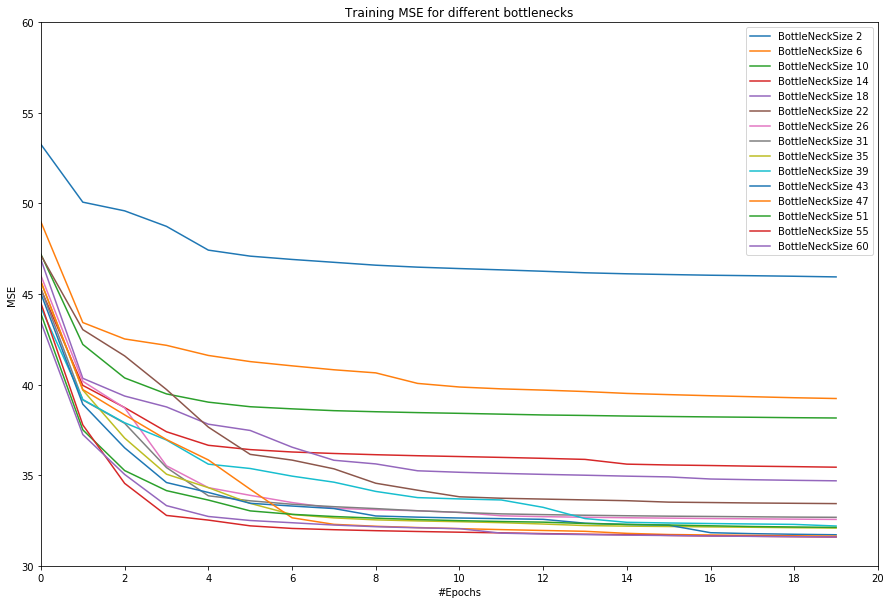

In [0]:
trainlosses = [los["trainLoss"] for los in loss]
vallosses = [los["validationLoss"] for los in loss]

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.axis([0 ,20,30,60 ])
ax.plot(range(hparams["num_epochs"]),np.array(trainlosses).T)
ax.legend([ f"BottleNeckSize {bottleneckSize}" for bottleneckSize in bottleneckSizes])
ax.set_xlabel('#Epochs')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_title('Training MSE for different bottlenecks')

Text(0.5, 1.0, 'Vaalidation MSE for different bottlenecks')

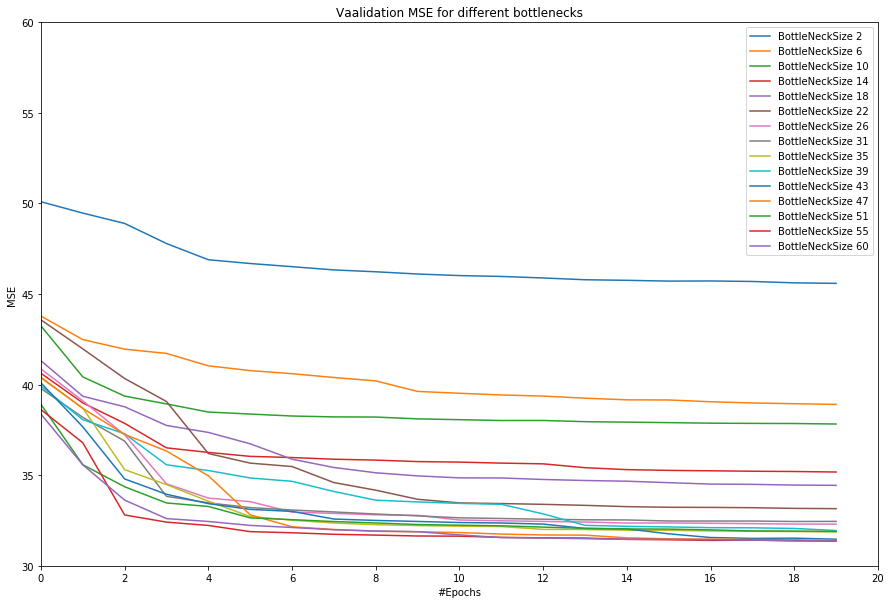

In [0]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.axis([0 ,20,30,60 ])
ax.plot(range(hparams["num_epochs"]),np.array(vallosses).T)
ax.legend([ f"BottleNeckSize {bottleneckSize}" for bottleneckSize in bottleneckSizes])
ax.set_xlabel('#Epochs')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_title('Vaalidation MSE for different bottlenecks')

## Image reconstruction error (MSE) on the MNIST validation and test sets.

In [0]:
device = torch.device("cpu")
costFunc = nn.MSELoss()
testLoss =[]
validationLoss =[]
bottleneckSizes = np.linspace(2,60,15,dtype=np.int32)
def num_params(model):
  return sum(p.numel() for p in model.parameters())

for i,model in enumerate(models):
    model.eval()
    model.to("cpu")
    for index,(data,_)  in enumerate(val_loader):
      data = data.to(device)
      prediction = model(data)
      loss = costFunc(prediction,data)
      valloss = loss.item()
      validationLoss.append({"bottleneckSize":bottleneckSizes[i],"validationLoss":valloss,"#params": num_params(model) })
    for index,(data,_)  in enumerate(test_loader):
      data = data.to(device)
      prediction = model(data)
      loss = costFunc(prediction,data)
      testloss = loss.item()
      testLoss.append({"bottleneckSize":bottleneckSizes[i],"testLoss":testloss,"#params": num_params(model)})

pd.set_option('display.max_rows', None)
validationtable= pd.DataFrame(validationLoss)
testtable =pd.DataFrame(testLoss)
display(validationtable)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,bottleneckSize,validationLoss,#params
0,2,0.690661,2059
1,2,0.713788,2059
2,2,0.698261,2059
3,2,0.690687,2059
4,2,0.658988,2059
5,2,0.718877,2059
6,2,0.692386,2059
7,2,0.757453,2059
8,2,0.720737,2059
9,2,0.699701,2059


In [0]:
display(testtable)

,bottleneckSize,testLoss,#params
0,2,0.670056,2059
1,2,0.686132,2059
2,2,0.675145,2059
3,2,0.671008,2059
4,2,0.704571,2059
5,2,0.666328,2059
6,2,0.684906,2059
7,2,0.707683,2059
8,2,0.701486,2059
9,2,0.710933,2059


## Showing original images and their reconstruction.
Now we take a bunch of images from the test set and see how the network behaves after being trained.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


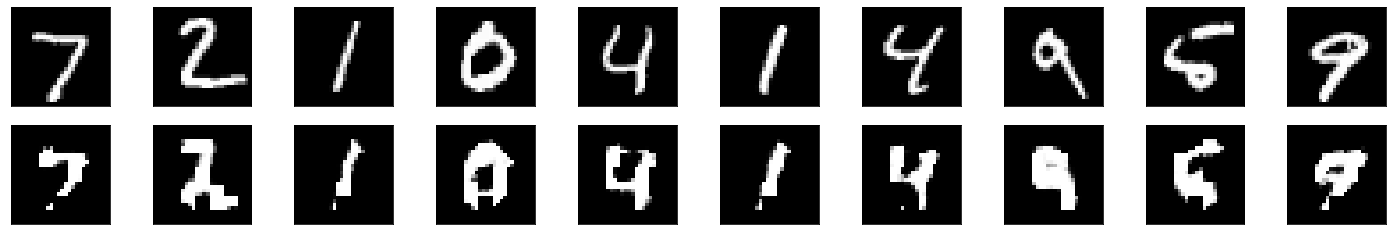

In [11]:
dataiter = iter(test_loader)
images, _ = dataiter.next()
#### encoder_decoder = models[14]
encoder_decoder = model
encoder_decoder.eval()
encoder_decoder.to("cpu")

prediction = encoder_decoder(images)
images = images.numpy()

prediction = prediction.detach().numpy()
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, prediction], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Generating images by injecting random values as input to the decoder

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


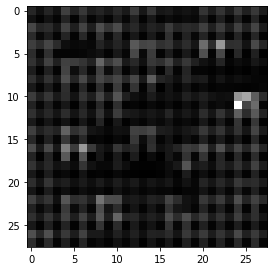

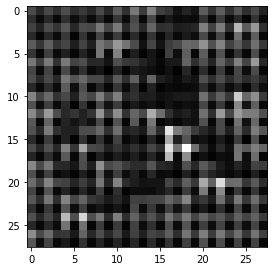

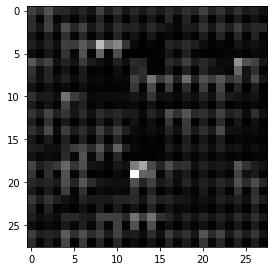

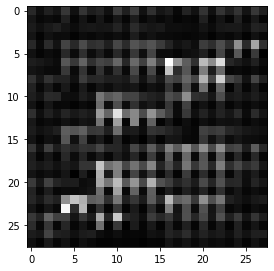

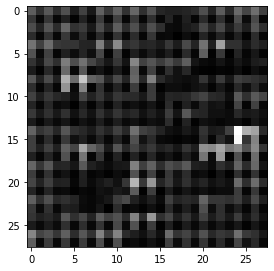

In [0]:
model = models[14]
model.eval()
model.to("cpu")

bottleneckSize=60
numimgs = 5

with torch.no_grad():
  rndnoise =torch.randn(numimgs,bottleneckSize)
  genimages = model.decoder(rndnoise).numpy()
  
for i in range(numimgs):
  img = np.squeeze(genimages[i])
  fig = plt.figure(figsize = (25,25))
  ax = fig.add_subplot(1,5,i+1)
  ax.imshow(img, cmap = 'gray')

# Exercice 2

In [0]:
hparams_class = {
    'batch_size':50,
    'num_epochs':30,
    'val_batch_size':50,
    'test_batch_size':50,
    'hidden_size':50,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck_size':10
}

In [0]:
class FeatureClassifier(nn.Module):
  
  def __init__(self, feature_extractor, feature_size, hidden_size, nclasses):
    super().__init__()
    self.feature_extractor = feature_extractor
    
    self.classifier = nn.Sequential(
        torch.nn.Linear(feature_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, nclasses),
        #torch.nn.Softmax(dim=-1)
    )
    

  def forward(self, x):
    out = self.feature_extractor(x)
    out = self.classifier(out)
    return out


In [18]:
m = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 100, 10)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(m)

14920

In [0]:
# From 
def accuracy(output, target):
  """Computes the accuracy for multiple binary predictions"""
  _, index = torch.max(output, dim=1)
  well_predictions = torch.eq(index, target)
  acc = torch.sum(well_predictions, 0)
  
  return acc.float()


In [0]:
def validate(hparams_class, classifier, crit, valid_dataloader, device):
  classifier.eval()

  n = 0
  with torch.no_grad():
    loss = 0
    acc = 0

    for x, label in valid_dataloader:
      x, label = x.to(device), label.to(device)
      
      pred = classifier(x)

      acc += accuracy(pred, label)
      loss += crit(pred, label)
      
      n += label.numel()
  loss = loss / n
  acc = acc / n

  return loss, acc
    

In [0]:
def watch_img(num=2,loader=None ):
  digits = []
  for i in range(num):
    iterator = iter(loader)
    images, _ = iterator.next()

    # Get first image of the batch
    digits.append(images.numpy()[0])

  fig, axes = plt.subplots(nrows=1, ncols=num, sharex=True, sharey=True, figsize=(25,4))

  for images, ax in zip(digits, axes):
      for img in images:
          ax.imshow(np.squeeze(img), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

In [0]:
def train_classifier(hparams_class, classifier, optim, crit, train_dataloader, valid_dataloader, device, name):
  
  classifier.to(device)
  classifier.train()

  N_epoch = hparams_class["num_epochs"]

  metrics =  {"batch_num": [],
              "batch_train_loss": [],
              "epoch_num": [],
              "epoch_val_loss": [],
              "epoch_val_acc": [],
              "epoch_train_loss": [],
              "epoch_train_acc": []
              }


  for n in range(N_epoch):
    for i, (input_batch, target_batch) in enumerate(train_dataloader):
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
      optim.zero_grad()
      prediction = classifier(input_batch)

      loss = crit(prediction, target_batch) / prediction.numel()

      loss.backward()
      optim.step()

      metrics["batch_num"].append(i+1)
      metrics["batch_train_loss"].append(loss.detach().cpu().numpy())

      
    val_loss, val_acc = validate(hparams_class, classifier, crit, valid_dataloader, device)
    
    metrics["epoch_num"].append(n+1)
    metrics["epoch_val_loss"].append(val_loss.detach().cpu().numpy())
    metrics["epoch_val_acc"].append(val_acc.detach().cpu().numpy())
    metrics["epoch_train_loss"].append(np.mean(metrics["batch_train_loss"]))

    print("Epoch {}, Loss: {:.6f}, Acc_val: {:.1f}%,  {}".format(metrics["epoch_num"][n], metrics["epoch_val_loss"][n], metrics["epoch_val_acc"][n]*100, name))
    
    
  metrics = {k: np.array(metrics[k]) for k in metrics.keys()}
  print("-"*55)

  return metrics

Thus we have 2 full batches of train and 60 full batches of validation


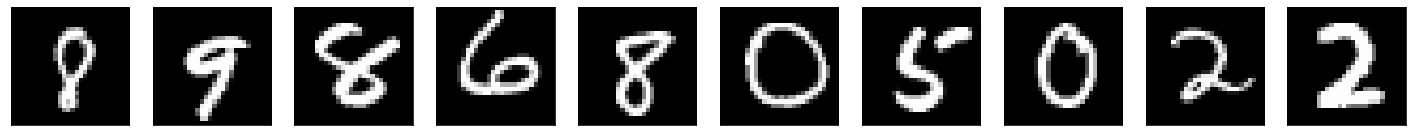

In [29]:

#encoder_decoder = models[x]
encoder_decoder = model

# From scatch
model_scratch = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                  hparams_class["hidden_size"], hparams_class["num_classes"])



#Initialize with pretrained ecoder
model_pretrained1 = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                      hparams_class["hidden_size"], hparams_class["num_classes"])
model_pretrained1.feature_extractor.load_state_dict(encoder_decoder.encoder.state_dict())

#Initialize with pretrained ecoder
model_pretrained2 = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                      hparams_class["hidden_size"], hparams_class["num_classes"])
model_pretrained2.feature_extractor.load_state_dict(encoder_decoder.encoder.state_dict())


small_train_dataset , _ = torch.utils.data.random_split(train_dataset, [100, len(train_dataset) - 100])

small_train_dataloader = torch.utils.data.DataLoader(small_train_dataset, batch_size = hparams_class["batch_size"], shuffle=True)

small_validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size = hparams_class['val_batch_size'], shuffle=True,drop_last=True)




crit = nn.CrossEntropyLoss(reduction="sum")  #nn.BCELoss()


optim1 = optim.Adam(model_scratch.parameters(), lr = hparams['learning_rate']) #From scratch same lr
optim2 = optim.Adam(model_pretrained1.classifier.parameters(), lr = hparams['learning_rate']) #From encoder weights same lr
optim3 = optim.Adam([{"params": model_pretrained2.feature_extractor.parameters(), "lr": hparams['learning_rate']/100}, 
                     {"params": model_pretrained2.classifier.parameters(), "lr": hparams['learning_rate']}],)  #From encoder weights diferent lr



watch_img(10, small_train_dataloader)
print("Thus we have {} full batches of train and {} full batches of validation".format(len(small_train_dataloader),len(small_validation_dataloader )))

In [30]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print(device)

model1 = train_classifier(hparams_class, model_scratch, optim1, crit, small_train_dataloader, small_validation_dataloader, device, name="Scratch")
model2 = train_classifier(hparams_class, model_pretrained1, optim2, crit, small_train_dataloader, small_validation_dataloader, device, name="Freeze enc")
model3 = train_classifier(hparams_class, model_pretrained2, optim3, crit, small_train_dataloader, small_validation_dataloader, device, name="Small LR enc")



cuda
Epoch 1, Loss: 2.301376, Acc_val: 10.6%,  Scratch
Epoch 2, Loss: 2.299084, Acc_val: 13.1%,  Scratch
Epoch 3, Loss: 2.296476, Acc_val: 18.3%,  Scratch
Epoch 4, Loss: 2.294116, Acc_val: 16.2%,  Scratch
Epoch 5, Loss: 2.291591, Acc_val: 14.6%,  Scratch
Epoch 6, Loss: 2.288568, Acc_val: 14.4%,  Scratch
Epoch 7, Loss: 2.284966, Acc_val: 14.4%,  Scratch
Epoch 8, Loss: 2.281881, Acc_val: 12.5%,  Scratch
Epoch 9, Loss: 2.279243, Acc_val: 10.2%,  Scratch
Epoch 10, Loss: 2.276731, Acc_val: 10.0%,  Scratch
Epoch 11, Loss: 2.274606, Acc_val: 9.8%,  Scratch
Epoch 12, Loss: 2.267972, Acc_val: 13.2%,  Scratch
Epoch 13, Loss: 2.253726, Acc_val: 16.4%,  Scratch
Epoch 14, Loss: 2.236250, Acc_val: 18.3%,  Scratch
Epoch 15, Loss: 2.216542, Acc_val: 19.5%,  Scratch
Epoch 16, Loss: 2.190898, Acc_val: 20.3%,  Scratch
Epoch 17, Loss: 2.155094, Acc_val: 23.0%,  Scratch
Epoch 18, Loss: 2.113903, Acc_val: 27.0%,  Scratch
Epoch 19, Loss: 2.063604, Acc_val: 32.5%,  Scratch
Epoch 20, Loss: 2.003263, Acc_val: 3

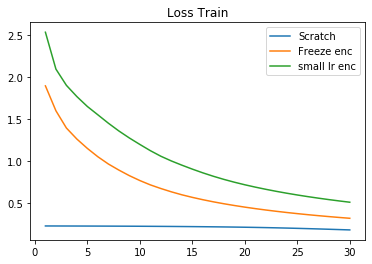

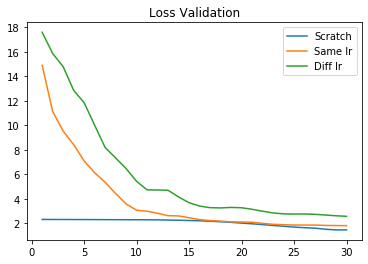

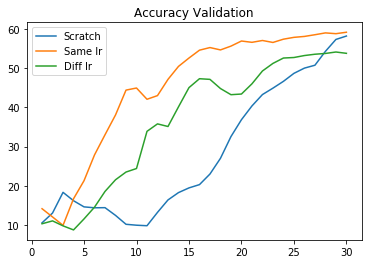

In [31]:

#Loss train Plot
plt.figure()
plt.title("Loss Train")
plt.plot(model1["epoch_num"], model1["epoch_train_loss"], label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_train_loss"], label="Freeze enc")
plt.plot(model3["epoch_num"], model3["epoch_train_loss"], label="small lr enc")
plt.legend()

#Loss Validation Plot
plt.figure()
plt.title("Loss Validation")
plt.plot(model1["epoch_num"], model1["epoch_val_loss"], label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_val_loss"], label="Same lr")
plt.plot(model3["epoch_num"], model3["epoch_val_loss"], label="Diff lr")
plt.legend()

#Accuracy Validation Plot
plt.figure()
plt.title("Accuracy Validation")
plt.plot(model1["epoch_num"], model1["epoch_val_acc"]*100, label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_val_acc"]*100, label="Same lr")
plt.plot(model3["epoch_num"], model3["epoch_val_acc"]*100, label="Diff lr")
plt.legend()




# Exercici Optional A

In [0]:
from torch.autograd.variable import Variable


In [0]:
class Encoder(nn.Module):
   ''' 
   This the encoder part of the VAE
   '''
   def __init__(self, bottleneck):
     super().__init__()

     self.conv1 = nn.Conv2d(1,32,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(32,16,3,padding=1)
     self.conv3 = nn.Conv2d(16,8,3,padding=1)
     self.fc      = nn.Linear(8*7*7, bottleneck)
     self.media = nn.Linear(bottleneck,bottleneck)
     self.logvar  = nn.Linear(bottleneck,bottleneck)

   def forward(self,x):
      ## encode ##


      x = F.relu(self.conv1(x))
      x = self.pool(x)
      x = F.relu(self.conv2(x))
      x = self.pool(x)
      x = F.relu(self.conv3(x))
      x = x.view(-1, 8*7*7)
      x = F.relu(self.fc(x))
      z_media = self.media(x)
      logvar   = self.logvar(x)

      return z_media, logvar

class Decoder(nn.Module):
   ''' 
   This the decoder part of the VAE
   '''

   def __init__(self, bottleneck):
     super().__init__()

     ## decoder layers ##
     ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
     self.linear = nn.Linear(bottleneck, 8*7*7)
     self.t_conv1 = nn.ConvTranspose2d(8, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 32, 2, stride=2)
     self.t_conv3 = nn.ConvTranspose2d(32,1,1)

   def forward(self,x):
     ## decode ##
     x = F.relu(self.linear(x))
     x = x.view(-1, 8, 7, 7)
     x = F.relu(self.t_conv1(x))
     # output layer (with sigmoid for scaling from 0 to 1)
     x = F.relu(self.t_conv2(x))
     x = torch.sigmoid(self.t_conv3(x))
            
     return x

class VAE(nn.Module):
  '''
  This takes both encoder and decoder into the same network
  '''
  def __init__(self, enc, dec):
    super().__init__()

    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    #encode
    z_media,logvar = self.encoder(x)
  
    # Reparametrization trick
    std = torch.exp(0.5*logvar)
    # Standard Gaussian with correct size
    eps = torch.randn_like(std)
    # This allows for the gradients to flow
    x_sample = z_media + eps*std
 
    #Decode
    predicted = self.decoder(x_sample)

    return predicted,z_media,logvar
      

In [0]:
def lossFunction(data,z_mu,logvar,prediction):
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(prediction, data, reduction='sum')
    # KL divergence loss
    kld = -0.5 * torch.sum(1+logvar - z_mu.pow(2) - logvar.exp()) * 600 #This 600 is the disentangle parameter.

    # total loss
    loss = recon_loss + kld
    return loss, recon_loss, kld


def train(model, num_epochs):
  # Prepare the GPU and the model to start training
  model.train()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = hparams['learning_rate']) # learning rate chosen at random
  
  for epoch in range(num_epochs):
    # For tracking the loss of the model
    closs = 0
    crl, ckdl = 0, 0
    for batch_idx, (data,_) in enumerate(train_loader):
      # Put data and label into GPU
      data = data.to(device)
      
      # What does the model say 
      prediction, z_mu,logvar = model(data)
      loss, rl, kdl = lossFunction(data,z_mu,logvar,prediction)
      closs += loss.item() 
      crl += rl
      ckdl += kdl
      # Name a more iconic trio
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print('Epoch: {} \tRecon Loss: {:.6f}\tKDL Loss: {:.6f}'.format(epoch+1,crl/len(mnist_trainset), ckdl/len(mnist_trainset)))  



In [34]:
BotNeck = 20

encoder = Encoder(BotNeck)
decoder = Decoder(BotNeck)
model = VAE(encoder,decoder)


train(model,30)

Epoch: 1 	Recon Loss: -7369.345215	KDL Loss: 36.088249
Epoch: 2 	Recon Loss: -8534.676758	KDL Loss: 42.878628
Epoch: 3 	Recon Loss: -7356.342285	KDL Loss: 21.832186
Epoch: 4 	Recon Loss: -7043.814941	KDL Loss: 23.705986
Epoch: 5 	Recon Loss: -6887.547852	KDL Loss: 48.470131
Epoch: 6 	Recon Loss: -6348.008789	KDL Loss: 61.951015
Epoch: 7 	Recon Loss: -5855.390137	KDL Loss: 69.641083
Epoch: 8 	Recon Loss: -5598.028320	KDL Loss: 78.989410
Epoch: 9 	Recon Loss: -5504.779785	KDL Loss: 88.566658
Epoch: 10 	Recon Loss: -5459.975098	KDL Loss: 102.301041
Epoch: 11 	Recon Loss: -5384.521484	KDL Loss: 130.769440
Epoch: 12 	Recon Loss: -5371.774414	KDL Loss: 176.827789
Epoch: 13 	Recon Loss: -5407.018555	KDL Loss: 211.618576
Epoch: 14 	Recon Loss: -5459.463867	KDL Loss: 234.230316
Epoch: 15 	Recon Loss: -5479.630371	KDL Loss: 253.644501
Epoch: 16 	Recon Loss: -5484.348145	KDL Loss: 260.966797
Epoch: 17 	Recon Loss: -5489.797852	KDL Loss: 268.401123
Epoch: 18 	Recon Loss: -5494.888184	KDL Loss: 272

KeyboardInterrupt: ignored

torch.Size([1, 20])
torch.Size([28, 28])


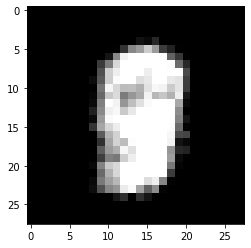

In [36]:
# sample and generate a image
z = torch.randn(1, BotNeck)
model.to("cpu")
# run only the decoder
reconstructed_img = model.decoder(z)

# Go home and run this.
print(z.shape)
print(reconstructed_img.detach().squeeze().shape)

plt.imshow(reconstructed_img.detach().squeeze().numpy(), cmap='gray')

# Exercice Optional B



In [0]:
from torch.autograd.variable import Variable
import random
import math
from torchvision import utils
from PIL import Image


In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()

def id_to_onehot(id):
    tgt = torch.zeros(id.shape[0], 10)
    for i in range(tgt.shape[0]):
      tgt[i, int(id[i])] = 1.0
    return tgt.float().cuda()



def rand_labels(size):
    lbls = torch.zeros(size, 10)
    for i in range(size):
        clss_i = random.randint(0, 9)
        lbls[i, clss_i] = 1
    #return torch.randint(low=0, high=10, size=[size, 1]).float().cuda()
    return lbls.float().cuda()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
      
        self._fc = torch.nn.Linear(100 + 10, 1024*4*4)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x, labs):
        # Noise to image
        x = torch.cat([x, labs], dim=1)
        x = self._fc(x)
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        return self._conv3(x)

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._fc1 = nn.Sequential(
            nn.Linear(512*4*4 + 10, 100),
            nn.ReLU()
        )
        self._fc2 = nn.Sequential(
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labs):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        x = x.view(-1, 512*4*4)
        x = torch.cat([x, labs], dim=1)
        x = self._fc1(x)
        x = self._fc2(x)
        return x

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def gen_nonmatching_labels(self, labels):
        labels_tgt = torch.zeros(*labels.shape)
        for i in range(labels.shape[0]):
            j = random.randint(0, 9)
            while labels[i, j] != 0:
                j = random.randint(0, 9)
            labels_tgt[i, j] = 1
        return labels_tgt.cuda()


    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None, lab=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
        if lab is None:
            lab = rand_labels(batch_size)


        # TODO: generate fake samples out of the random noise z
        fake_samples = self._generator(z, lab)
        return fake_samples, lab
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, real_labels):
        # generate fake samples
        fake_samples, fake_labels = self.generate_samples(real_samples.size(0))

        # optimize generator
        loss_g = self._step_opt_g(fake_samples, fake_labels)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, real_labels, fake_samples.detach(), fake_labels.detach())
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, fake_labels):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # TODO: Calculate generator loss
        estim_fake = self._discriminator(fake_samples, fake_labels)

        # Generate fake sample target
        # tgt = torch.zeros(estim_fake.shape[0], 1)

        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, real_labels, fake_samples, fake_labels):
        # Reset gradients
        self._opt_d.zero_grad()

        # Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples, real_labels)
        loss_real = self._criterion(estim_real, self._label_real)

      
        # Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples, fake_labels)
        loss_fake = self._criterion(estim_fake, self._label_fake)

        # Calculate discriminator loss for non-matching labels and images
        fake_labels2 = self.gen_nonmatching_labels(real_labels)
        estim_real_fakelabs = self._discriminator(real_samples, fake_labels2)
        loss_nonmatching = self._criterion(estim_real_fakelabs, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake + loss_nonmatching) / 3
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item(), loss_nonmatching.item()
        
  

In [0]:
num_epochs = 300
num_val_samples = 25
batch_size
z_val = norm_noise(num_val_samples)

labs_val = torch.zeros(num_val_samples, 10)

for i in range(num_val_samples):
    labs_val[i, i%10] = 1
labs_val = labs_val.float().cuda()



model = Model(batch_size)

epoch: 0/300, batch: 0/600, G_loss: 0.6823503375053406, D_loss: (0.6896668076515198, 0.7040635943412781, 0.6960944533348083)


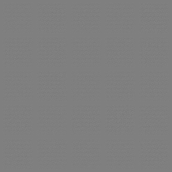

epoch: 0/300, batch: 10/600, G_loss: 0.9334901571273804, D_loss: (0.8224533796310425, 0.499574214220047, 0.5784337520599365)
epoch: 0/300, batch: 20/600, G_loss: 1.4482104778289795, D_loss: (0.7791535258293152, 0.26803380250930786, 0.6171227097511292)
epoch: 0/300, batch: 30/600, G_loss: 2.258741855621338, D_loss: (0.8255955576896667, 0.11037299782037735, 0.5770916938781738)
epoch: 0/300, batch: 40/600, G_loss: 2.8587920665740967, D_loss: (0.8416311144828796, 0.059242624789476395, 0.5655633211135864)
epoch: 0/300, batch: 50/600, G_loss: 2.7899017333984375, D_loss: (0.5760172605514526, 0.06424229592084885, 0.8295539021492004)
epoch: 0/300, batch: 60/600, G_loss: 3.5147430896759033, D_loss: (0.9623992443084717, 0.030473539605736732, 0.4904276132583618)
epoch: 0/300, batch: 70/600, G_loss: 3.8132336139678955, D_loss: (0.8424221277236938, 0.02259095199406147, 0.5643349289894104)
epoch: 0/300, batch: 80/600, G_loss: 2.8028130531311035, D_loss: (0.4330120086669922, 0.07049351930618286, 1.055

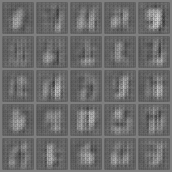

epoch: 0/300, batch: 110/600, G_loss: 3.112100839614868, D_loss: (0.8135921359062195, 0.04689290001988411, 0.5927937626838684)
epoch: 0/300, batch: 120/600, G_loss: 3.4963061809539795, D_loss: (0.7726611495018005, 0.03141925111413002, 0.6265783309936523)
epoch: 0/300, batch: 130/600, G_loss: 2.3238680362701416, D_loss: (0.6221271753311157, 0.10783092677593231, 0.775144636631012)
epoch: 0/300, batch: 140/600, G_loss: 3.1963183879852295, D_loss: (0.6651905179023743, 0.044125042855739594, 0.7278300523757935)
epoch: 0/300, batch: 150/600, G_loss: 1.703477144241333, D_loss: (0.5452420711517334, 0.20631097257137299, 0.871504545211792)
epoch: 0/300, batch: 160/600, G_loss: 3.374330997467041, D_loss: (0.8862694501876831, 0.036146800965070724, 0.5407166481018066)
epoch: 0/300, batch: 170/600, G_loss: 2.2895302772521973, D_loss: (0.7681241035461426, 0.10920072346925735, 0.6307029128074646)
epoch: 0/300, batch: 180/600, G_loss: 2.7198243141174316, D_loss: (0.8246470093727112, 0.07022476941347122,

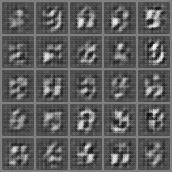

epoch: 0/300, batch: 210/600, G_loss: 3.5045506954193115, D_loss: (0.8829656839370728, 0.031508494168519974, 0.5417249202728271)
epoch: 0/300, batch: 220/600, G_loss: 3.5169968605041504, D_loss: (0.7805625200271606, 0.03117482177913189, 0.6169577836990356)
epoch: 0/300, batch: 230/600, G_loss: 3.1172070503234863, D_loss: (0.709038496017456, 0.047209519892930984, 0.6798698306083679)
epoch: 0/300, batch: 240/600, G_loss: 2.8004486560821533, D_loss: (0.7637982964515686, 0.06512255221605301, 0.6301065683364868)
epoch: 0/300, batch: 250/600, G_loss: 3.112304925918579, D_loss: (0.7803023457527161, 0.04738744720816612, 0.615648627281189)
epoch: 0/300, batch: 260/600, G_loss: 3.495027780532837, D_loss: (0.7208355069160461, 0.03219839558005333, 0.6698886752128601)
epoch: 0/300, batch: 270/600, G_loss: 3.3347525596618652, D_loss: (0.6144586801528931, 0.03937295451760292, 0.7818191647529602)
epoch: 0/300, batch: 280/600, G_loss: 0.8228943347930908, D_loss: (0.3477291464805603, 0.5882555842399597,

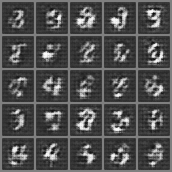

epoch: 0/300, batch: 310/600, G_loss: 3.9176080226898193, D_loss: (0.7856020927429199, 0.021029410883784294, 0.6162852644920349)
epoch: 0/300, batch: 320/600, G_loss: 1.422645092010498, D_loss: (0.8765398263931274, 0.2796543836593628, 0.5412302613258362)
epoch: 0/300, batch: 330/600, G_loss: 0.891387939453125, D_loss: (0.4513601064682007, 0.5361849069595337, 1.010513186454773)
epoch: 0/300, batch: 340/600, G_loss: 2.8947553634643555, D_loss: (0.8397443294525146, 0.06091378629207611, 0.570048987865448)
epoch: 0/300, batch: 350/600, G_loss: 2.5426723957061768, D_loss: (0.6756346225738525, 0.08620622009038925, 0.7135495543479919)
epoch: 0/300, batch: 360/600, G_loss: 3.12949800491333, D_loss: (0.8366652727127075, 0.049336377531290054, 0.5705780982971191)
epoch: 0/300, batch: 370/600, G_loss: 1.831146240234375, D_loss: (0.8942765593528748, 0.17864936590194702, 0.5326656103134155)
epoch: 0/300, batch: 380/600, G_loss: 4.833792686462402, D_loss: (1.710631251335144, 0.008721772581338882, 0.21

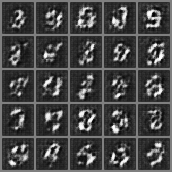

epoch: 0/300, batch: 410/600, G_loss: 3.4839816093444824, D_loss: (0.7910956740379333, 0.03400851786136627, 0.6104795932769775)
epoch: 0/300, batch: 420/600, G_loss: 4.422344207763672, D_loss: (1.0329499244689941, 0.013804428279399872, 0.4511222541332245)
epoch: 0/300, batch: 430/600, G_loss: 3.3852744102478027, D_loss: (0.943053662776947, 0.038084663450717926, 0.49946364760398865)
epoch: 0/300, batch: 440/600, G_loss: 3.4839415550231934, D_loss: (0.7575916051864624, 0.03398210555315018, 0.6351222991943359)
epoch: 0/300, batch: 450/600, G_loss: 2.965555191040039, D_loss: (0.7253332734107971, 0.05800068378448486, 0.6594483256340027)
epoch: 0/300, batch: 460/600, G_loss: 3.3498053550720215, D_loss: (0.6625356078147888, 0.03945840895175934, 0.7248532772064209)
epoch: 0/300, batch: 470/600, G_loss: 4.620587348937988, D_loss: (0.7843669056892395, 0.010790306143462658, 0.6101561784744263)
epoch: 0/300, batch: 480/600, G_loss: 0.824571967124939, D_loss: (0.6319844126701355, 0.5806261897087097

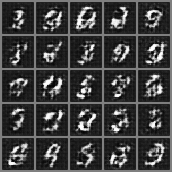

epoch: 0/300, batch: 510/600, G_loss: 1.5797005891799927, D_loss: (0.8958873152732849, 0.24325747787952423, 0.5311234593391418)
epoch: 0/300, batch: 520/600, G_loss: 1.735352635383606, D_loss: (0.7693885564804077, 0.20111072063446045, 0.6330724954605103)
epoch: 0/300, batch: 530/600, G_loss: 2.4750936031341553, D_loss: (0.8130836486816406, 0.10116451233625412, 0.5924462080001831)
epoch: 0/300, batch: 540/600, G_loss: 3.654407024383545, D_loss: (0.8488813042640686, 0.028432659804821014, 0.5629304647445679)
epoch: 0/300, batch: 550/600, G_loss: 3.624504327774048, D_loss: (0.833860456943512, 0.028930868953466415, 0.5797227621078491)
epoch: 0/300, batch: 560/600, G_loss: 1.3835586309432983, D_loss: (0.966976523399353, 0.29657307267189026, 0.4874400198459625)
epoch: 0/300, batch: 570/600, G_loss: 1.941736102104187, D_loss: (0.8987285494804382, 0.16331495344638824, 0.5258677005767822)
epoch: 0/300, batch: 580/600, G_loss: 1.8261767625808716, D_loss: (1.1359645128250122, 0.18579743802547455, 

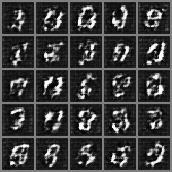

epoch: 1/300, batch: 10/600, G_loss: 2.808042526245117, D_loss: (0.9146145582199097, 0.06605735421180725, 0.5275220274925232)
epoch: 1/300, batch: 20/600, G_loss: 2.930586338043213, D_loss: (0.9390850067138672, 0.058667607605457306, 0.4995138943195343)
epoch: 1/300, batch: 30/600, G_loss: 1.0224120616912842, D_loss: (0.7227404117584229, 0.45129454135894775, 0.6652882099151611)
epoch: 1/300, batch: 40/600, G_loss: 2.6869289875030518, D_loss: (0.8268001675605774, 0.07473806291818619, 0.5848827958106995)
epoch: 1/300, batch: 50/600, G_loss: 1.2273623943328857, D_loss: (1.0467314720153809, 0.35050591826438904, 0.4358603358268738)
epoch: 1/300, batch: 60/600, G_loss: 2.3574306964874268, D_loss: (0.9506530165672302, 0.1100834384560585, 0.4929276704788208)
epoch: 1/300, batch: 70/600, G_loss: 1.4082015752792358, D_loss: (0.7597959637641907, 0.30135881900787354, 0.6308407783508301)
epoch: 1/300, batch: 80/600, G_loss: 3.0020229816436768, D_loss: (0.9637951850891113, 0.055457841604948044, 0.491

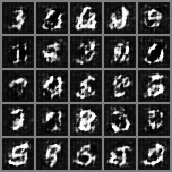

epoch: 1/300, batch: 110/600, G_loss: 2.560044050216675, D_loss: (0.9595731496810913, 0.0856809988617897, 0.4812590777873993)
epoch: 1/300, batch: 120/600, G_loss: 0.7972151041030884, D_loss: (0.6225744485855103, 0.6017873883247375, 0.7664090991020203)
epoch: 1/300, batch: 130/600, G_loss: 2.616588830947876, D_loss: (0.9413947463035583, 0.08535012602806091, 0.49926093220710754)
epoch: 1/300, batch: 140/600, G_loss: 3.4115700721740723, D_loss: (1.00442636013031, 0.03818649798631668, 0.4671580195426941)
epoch: 1/300, batch: 150/600, G_loss: 4.450911998748779, D_loss: (1.084639549255371, 0.013474558480083942, 0.4398242235183716)
epoch: 1/300, batch: 160/600, G_loss: 1.3920300006866455, D_loss: (0.6665757894515991, 0.30348441004753113, 0.7152732014656067)
epoch: 1/300, batch: 170/600, G_loss: 3.8233261108398438, D_loss: (0.8276143074035645, 0.0247021596878767, 0.5765926837921143)
epoch: 1/300, batch: 180/600, G_loss: 2.7632126808166504, D_loss: (0.7109424471855164, 0.07282741367816925, 0.6

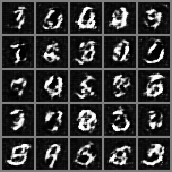

epoch: 1/300, batch: 210/600, G_loss: 4.219598293304443, D_loss: (1.4572539329528809, 0.01744968816637993, 0.29089468717575073)
epoch: 1/300, batch: 220/600, G_loss: 2.910205125808716, D_loss: (0.9372421503067017, 0.06563764810562134, 0.4996499717235565)
epoch: 1/300, batch: 230/600, G_loss: 1.6310186386108398, D_loss: (0.7957594990730286, 0.2372657060623169, 0.5991703867912292)
epoch: 1/300, batch: 240/600, G_loss: 4.721799850463867, D_loss: (1.7769421339035034, 0.010099620558321476, 0.20906585454940796)
epoch: 1/300, batch: 250/600, G_loss: 1.422369122505188, D_loss: (1.020952820777893, 0.27913758158683777, 0.4435267746448517)
epoch: 1/300, batch: 260/600, G_loss: 2.767676591873169, D_loss: (1.0043011903762817, 0.07297448813915253, 0.47582972049713135)
epoch: 1/300, batch: 270/600, G_loss: 1.482254981994629, D_loss: (0.6595567464828491, 0.2843587398529053, 0.7266089916229248)
epoch: 1/300, batch: 280/600, G_loss: 2.4248430728912354, D_loss: (0.930329442024231, 0.1053629219532013, 0.5

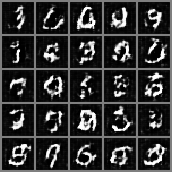

epoch: 1/300, batch: 310/600, G_loss: 2.2737467288970947, D_loss: (0.7918717265129089, 0.12473749369382858, 0.5956566333770752)
epoch: 1/300, batch: 320/600, G_loss: 3.082150459289551, D_loss: (0.7677252292633057, 0.05600748956203461, 0.6194249391555786)
epoch: 1/300, batch: 330/600, G_loss: 3.221240282058716, D_loss: (1.2120018005371094, 0.046267103403806686, 0.3587816655635834)
epoch: 1/300, batch: 340/600, G_loss: 3.7434046268463135, D_loss: (0.8562066555023193, 0.027051739394664764, 0.5609193444252014)
epoch: 1/300, batch: 350/600, G_loss: 3.791857957839966, D_loss: (0.8858550786972046, 0.025809405371546745, 0.5412461757659912)
epoch: 1/300, batch: 360/600, G_loss: 0.7809529304504395, D_loss: (0.5556119680404663, 0.6165539026260376, 0.8480966091156006)
epoch: 1/300, batch: 370/600, G_loss: 1.3864070177078247, D_loss: (1.032872200012207, 0.3056779205799103, 0.440946489572525)
epoch: 1/300, batch: 380/600, G_loss: 2.724680185317993, D_loss: (0.9939872622489929, 0.09066887944936752, 0

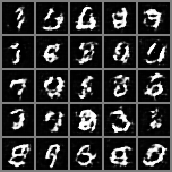

epoch: 1/300, batch: 410/600, G_loss: 0.8428497314453125, D_loss: (0.6069679856300354, 0.5673650503158569, 0.7775589227676392)
epoch: 1/300, batch: 420/600, G_loss: 2.6788060665130615, D_loss: (0.8438947200775146, 0.08106020838022232, 0.5636350512504578)
epoch: 1/300, batch: 430/600, G_loss: 0.9512543678283691, D_loss: (0.6019102334976196, 0.5010684728622437, 0.780036985874176)
epoch: 1/300, batch: 440/600, G_loss: 2.7319350242614746, D_loss: (0.77203369140625, 0.0742483139038086, 0.6064465045928955)
epoch: 1/300, batch: 450/600, G_loss: 1.2903637886047363, D_loss: (0.9460392594337463, 0.32520920038223267, 0.4852907657623291)
epoch: 1/300, batch: 460/600, G_loss: 0.9895734190940857, D_loss: (0.7625168561935425, 0.4704660475254059, 0.628717839717865)
epoch: 1/300, batch: 470/600, G_loss: 1.0797202587127686, D_loss: (0.8480737209320068, 0.4195982813835144, 0.5513378381729126)
epoch: 1/300, batch: 480/600, G_loss: 1.4235118627548218, D_loss: (0.7595861554145813, 0.299201637506485, 0.61907

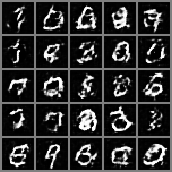

epoch: 1/300, batch: 510/600, G_loss: 0.8988265991210938, D_loss: (0.6366569995880127, 0.5307320952415466, 0.7447357177734375)
epoch: 1/300, batch: 520/600, G_loss: 2.6937105655670166, D_loss: (0.9430291652679443, 0.08118864893913269, 0.4932660162448883)
epoch: 1/300, batch: 530/600, G_loss: 1.1104103326797485, D_loss: (0.6492811441421509, 0.41873031854629517, 0.7214897274971008)
epoch: 1/300, batch: 540/600, G_loss: 1.8509283065795898, D_loss: (0.734743058681488, 0.18710117042064667, 0.6378777027130127)
epoch: 1/300, batch: 550/600, G_loss: 3.5940234661102295, D_loss: (1.2390694618225098, 0.03213445469737053, 0.3738032877445221)
epoch: 1/300, batch: 560/600, G_loss: 1.4818066358566284, D_loss: (0.9455879926681519, 0.265910267829895, 0.4855749011039734)
epoch: 1/300, batch: 570/600, G_loss: 2.5395820140838623, D_loss: (0.7167261242866516, 0.09408888220787048, 0.6592726111412048)
epoch: 1/300, batch: 580/600, G_loss: 4.003537178039551, D_loss: (1.2606638669967651, 0.02254287153482437, 0

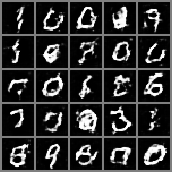

epoch: 2/300, batch: 10/600, G_loss: 1.1698253154754639, D_loss: (0.7090981006622314, 0.3823118209838867, 0.6554946303367615)
epoch: 2/300, batch: 20/600, G_loss: 3.6713638305664062, D_loss: (1.5094233751296997, 0.029144804924726486, 0.267325758934021)
epoch: 2/300, batch: 30/600, G_loss: 1.4910645484924316, D_loss: (1.0358909368515015, 0.2615227997303009, 0.4251920282840729)
epoch: 2/300, batch: 40/600, G_loss: 2.1386232376098633, D_loss: (0.9352138638496399, 0.15249454975128174, 0.4920561909675598)
epoch: 2/300, batch: 50/600, G_loss: 2.389254093170166, D_loss: (1.1014288663864136, 0.1107294112443924, 0.4021872282028198)
epoch: 2/300, batch: 60/600, G_loss: 2.6406850814819336, D_loss: (0.9540462493896484, 0.0937105193734169, 0.4758746027946472)
epoch: 2/300, batch: 70/600, G_loss: 1.9560127258300781, D_loss: (1.057633876800537, 0.17324836552143097, 0.4299409091472626)
epoch: 2/300, batch: 80/600, G_loss: 2.152393102645874, D_loss: (1.1502103805541992, 0.13872238993644714, 0.379298388

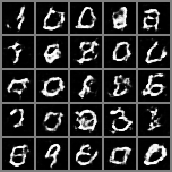

epoch: 2/300, batch: 110/600, G_loss: 2.3097922801971436, D_loss: (0.8152328729629517, 0.11962036788463593, 0.5681434273719788)
epoch: 2/300, batch: 120/600, G_loss: 2.098087787628174, D_loss: (0.8943776488304138, 0.15263846516609192, 0.505303680896759)
epoch: 2/300, batch: 130/600, G_loss: 2.712557792663574, D_loss: (0.7858026623725891, 0.07698527723550797, 0.5955134034156799)
epoch: 2/300, batch: 140/600, G_loss: 2.942697048187256, D_loss: (1.145106554031372, 0.06321629881858826, 0.37869319319725037)
epoch: 2/300, batch: 150/600, G_loss: 1.1961219310760498, D_loss: (0.6244975328445435, 0.383899986743927, 0.7393525838851929)
epoch: 2/300, batch: 160/600, G_loss: 1.7963000535964966, D_loss: (0.8604300618171692, 0.20143230259418488, 0.5262479186058044)
epoch: 2/300, batch: 170/600, G_loss: 2.9438858032226562, D_loss: (1.0363974571228027, 0.06143328174948692, 0.42947742342948914)
epoch: 2/300, batch: 180/600, G_loss: 3.2774088382720947, D_loss: (1.0628620386123657, 0.046274393796920776, 

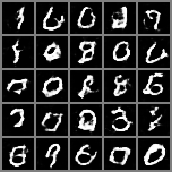

epoch: 2/300, batch: 210/600, G_loss: 1.2539979219436646, D_loss: (1.0201332569122314, 0.34150150418281555, 0.42949122190475464)
epoch: 2/300, batch: 220/600, G_loss: 1.3696500062942505, D_loss: (0.9865164160728455, 0.3045114576816559, 0.44164612889289856)
epoch: 2/300, batch: 230/600, G_loss: 1.6579262018203735, D_loss: (1.0725191831588745, 0.23531940579414368, 0.403005987405777)
epoch: 2/300, batch: 240/600, G_loss: 1.7068363428115845, D_loss: (0.9875306487083435, 0.21800768375396729, 0.4558015465736389)
epoch: 2/300, batch: 250/600, G_loss: 1.5014644861221313, D_loss: (0.8701629638671875, 0.2734972834587097, 0.5212170481681824)
epoch: 2/300, batch: 260/600, G_loss: 1.9767217636108398, D_loss: (1.2060235738754272, 0.16144147515296936, 0.33428412675857544)
epoch: 2/300, batch: 270/600, G_loss: 1.490418553352356, D_loss: (0.8341898322105408, 0.2726000249385834, 0.5394344925880432)
epoch: 2/300, batch: 280/600, G_loss: 1.7951933145523071, D_loss: (0.865680456161499, 0.19667798280715942,

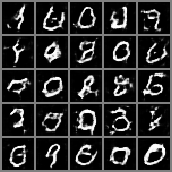

epoch: 2/300, batch: 310/600, G_loss: 2.3399055004119873, D_loss: (1.136263370513916, 0.11158295720815659, 0.3808281719684601)
epoch: 2/300, batch: 320/600, G_loss: 2.4312446117401123, D_loss: (1.2027167081832886, 0.10738496482372284, 0.34351643919944763)
epoch: 2/300, batch: 330/600, G_loss: 2.275581121444702, D_loss: (0.8979228734970093, 0.11970001459121704, 0.4880863130092621)
epoch: 2/300, batch: 340/600, G_loss: 1.352824091911316, D_loss: (0.637746274471283, 0.3238634467124939, 0.6866692900657654)
epoch: 2/300, batch: 350/600, G_loss: 2.3590166568756104, D_loss: (1.0168790817260742, 0.11139121651649475, 0.4076654016971588)
epoch: 2/300, batch: 360/600, G_loss: 1.055808663368225, D_loss: (0.608936071395874, 0.44868141412734985, 0.7217957973480225)
epoch: 2/300, batch: 370/600, G_loss: 1.8370951414108276, D_loss: (0.8376829624176025, 0.19289155304431915, 0.5296163558959961)
epoch: 2/300, batch: 380/600, G_loss: 1.2782772779464722, D_loss: (0.6671488285064697, 0.36540794372558594, 0.

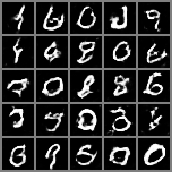

epoch: 2/300, batch: 410/600, G_loss: 1.3618507385253906, D_loss: (0.6142888069152832, 0.32337287068367004, 0.7052565217018127)
epoch: 2/300, batch: 420/600, G_loss: 1.8650394678115845, D_loss: (0.5973880290985107, 0.1994287520647049, 0.7258985638618469)
epoch: 2/300, batch: 430/600, G_loss: 1.1593459844589233, D_loss: (0.5321101546287537, 0.39807596802711487, 0.8114869594573975)
epoch: 2/300, batch: 440/600, G_loss: 2.693363666534424, D_loss: (0.9787470102310181, 0.08175421506166458, 0.44161468744277954)
epoch: 2/300, batch: 450/600, G_loss: 0.8240776062011719, D_loss: (0.49500346183776855, 0.5934818387031555, 0.872769832611084)
epoch: 2/300, batch: 460/600, G_loss: 1.8555951118469238, D_loss: (1.011411428451538, 0.19211579859256744, 0.4162089228630066)
epoch: 2/300, batch: 470/600, G_loss: 2.0104217529296875, D_loss: (0.728217363357544, 0.16823820769786835, 0.5842401385307312)
epoch: 2/300, batch: 480/600, G_loss: 1.430399775505066, D_loss: (0.5695768594741821, 0.31066393852233887, 0

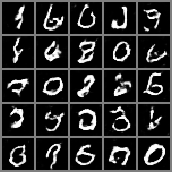

epoch: 2/300, batch: 510/600, G_loss: 1.8225750923156738, D_loss: (0.578133761882782, 0.2001887857913971, 0.7279987335205078)
epoch: 2/300, batch: 520/600, G_loss: 2.1390886306762695, D_loss: (0.6806362867355347, 0.14379335939884186, 0.6180872917175293)
epoch: 2/300, batch: 530/600, G_loss: 2.0832738876342773, D_loss: (0.6455544233322144, 0.1513856053352356, 0.6467440128326416)
epoch: 2/300, batch: 540/600, G_loss: 1.4719692468643188, D_loss: (0.6515480279922485, 0.2885194718837738, 0.652177095413208)
epoch: 2/300, batch: 550/600, G_loss: 2.023897409439087, D_loss: (0.8783733248710632, 0.1673162430524826, 0.46836861968040466)
epoch: 2/300, batch: 560/600, G_loss: 1.128867268562317, D_loss: (0.5568467974662781, 0.42512962222099304, 0.7457607984542847)
epoch: 2/300, batch: 570/600, G_loss: 1.52693772315979, D_loss: (0.9877258539199829, 0.26777467131614685, 0.4086732864379883)
epoch: 2/300, batch: 580/600, G_loss: 1.7430278062820435, D_loss: (0.9700227379798889, 0.21167248487472534, 0.392

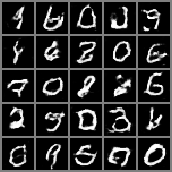

epoch: 3/300, batch: 10/600, G_loss: 1.8834965229034424, D_loss: (0.8466736674308777, 0.18741832673549652, 0.456696480512619)
epoch: 3/300, batch: 20/600, G_loss: 2.007174015045166, D_loss: (1.072077751159668, 0.16538968682289124, 0.36148521304130554)
epoch: 3/300, batch: 30/600, G_loss: 2.5732998847961426, D_loss: (1.2018073797225952, 0.08946051448583603, 0.32411566376686096)
epoch: 3/300, batch: 40/600, G_loss: 2.23649001121521, D_loss: (0.7815760970115662, 0.13563594222068787, 0.49230578541755676)
epoch: 3/300, batch: 50/600, G_loss: 1.385805368423462, D_loss: (0.6314119696617126, 0.30824944376945496, 0.6418111324310303)
epoch: 3/300, batch: 60/600, G_loss: 1.7371808290481567, D_loss: (0.6576729416847229, 0.21699395775794983, 0.618609607219696)
epoch: 3/300, batch: 70/600, G_loss: 1.2545841932296753, D_loss: (0.5171701908111572, 0.3652980923652649, 0.7639591097831726)
epoch: 3/300, batch: 80/600, G_loss: 2.0035758018493652, D_loss: (0.6759426593780518, 0.17416685819625854, 0.5669361

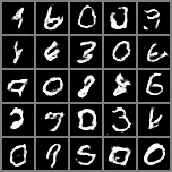

epoch: 3/300, batch: 110/600, G_loss: 2.6183512210845947, D_loss: (0.92734694480896, 0.09071233868598938, 0.41206493973731995)
epoch: 3/300, batch: 120/600, G_loss: 2.550630807876587, D_loss: (0.7194276452064514, 0.09868472069501877, 0.5240681171417236)
epoch: 3/300, batch: 130/600, G_loss: 2.993075370788574, D_loss: (0.9474904537200928, 0.06294355541467667, 0.40040165185928345)
epoch: 3/300, batch: 140/600, G_loss: 1.5873392820358276, D_loss: (0.7374778985977173, 0.2560344636440277, 0.514997124671936)
epoch: 3/300, batch: 150/600, G_loss: 1.4028677940368652, D_loss: (0.6459893584251404, 0.3093342185020447, 0.5977959632873535)
epoch: 3/300, batch: 160/600, G_loss: 2.1393754482269287, D_loss: (0.8762125372886658, 0.1404809206724167, 0.4149717688560486)
epoch: 3/300, batch: 170/600, G_loss: 2.3910984992980957, D_loss: (0.8879852890968323, 0.11371781677007675, 0.415343701839447)
epoch: 3/300, batch: 180/600, G_loss: 1.4715070724487305, D_loss: (0.5480783581733704, 0.28231704235076904, 0.6

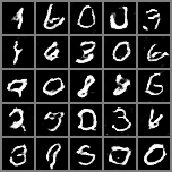

epoch: 3/300, batch: 210/600, G_loss: 2.0767393112182617, D_loss: (0.6354045271873474, 0.15804681181907654, 0.572344958782196)
epoch: 3/300, batch: 220/600, G_loss: 0.9669663906097412, D_loss: (0.3636976480484009, 0.5403234958648682, 0.9878650903701782)
epoch: 3/300, batch: 230/600, G_loss: 1.175894856452942, D_loss: (0.5185813307762146, 0.4163025915622711, 0.7115190625190735)
epoch: 3/300, batch: 240/600, G_loss: 2.4444077014923096, D_loss: (0.9177384376525879, 0.11025405675172806, 0.39489081501960754)
epoch: 3/300, batch: 250/600, G_loss: 2.163275718688965, D_loss: (0.6540673971176147, 0.1481260061264038, 0.5520727038383484)
epoch: 3/300, batch: 260/600, G_loss: 2.8654751777648926, D_loss: (0.8403905630111694, 0.07528649270534515, 0.4333803653717041)
epoch: 3/300, batch: 270/600, G_loss: 1.542719841003418, D_loss: (0.6591123342514038, 0.27054959535598755, 0.5843758583068848)
epoch: 3/300, batch: 280/600, G_loss: 1.676874041557312, D_loss: (0.6865659356117249, 0.22975704073905945, 0.4

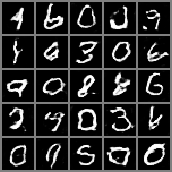

epoch: 3/300, batch: 310/600, G_loss: 3.2092037200927734, D_loss: (0.9487203359603882, 0.053780242800712585, 0.37272322177886963)
epoch: 3/300, batch: 320/600, G_loss: 2.1722218990325928, D_loss: (0.7020617127418518, 0.14479556679725647, 0.46782755851745605)
epoch: 3/300, batch: 330/600, G_loss: 2.4938888549804688, D_loss: (1.000317096710205, 0.10342969000339508, 0.315815806388855)
epoch: 3/300, batch: 340/600, G_loss: 2.1909470558166504, D_loss: (0.8928758502006531, 0.14572738111019135, 0.35468214750289917)
epoch: 3/300, batch: 350/600, G_loss: 2.558000087738037, D_loss: (0.8460376858711243, 0.10021047294139862, 0.38602352142333984)
epoch: 3/300, batch: 360/600, G_loss: 1.7062008380889893, D_loss: (0.5140665769577026, 0.24149587750434875, 0.6189647912979126)
epoch: 3/300, batch: 370/600, G_loss: 1.829045295715332, D_loss: (0.5734526515007019, 0.20947682857513428, 0.5478032231330872)
epoch: 3/300, batch: 380/600, G_loss: 2.8165838718414307, D_loss: (0.9789507985115051, 0.07897479832172

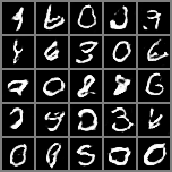

epoch: 3/300, batch: 410/600, G_loss: 1.7795133590698242, D_loss: (0.72442626953125, 0.21539297699928284, 0.47587820887565613)
epoch: 3/300, batch: 420/600, G_loss: 1.6225394010543823, D_loss: (0.6194624900817871, 0.2524760961532593, 0.5483335256576538)
epoch: 3/300, batch: 430/600, G_loss: 2.5337934494018555, D_loss: (0.6517701745033264, 0.10372740775346756, 0.5261799097061157)
epoch: 3/300, batch: 440/600, G_loss: 2.971698045730591, D_loss: (1.1542057991027832, 0.07731488347053528, 0.2557356357574463)
epoch: 3/300, batch: 450/600, G_loss: 2.6706302165985107, D_loss: (0.6896263360977173, 0.0941423773765564, 0.43788009881973267)
epoch: 3/300, batch: 460/600, G_loss: 1.8122804164886475, D_loss: (0.5263299345970154, 0.21398836374282837, 0.6048567295074463)
epoch: 3/300, batch: 470/600, G_loss: 1.9726290702819824, D_loss: (0.8626521825790405, 0.17328214645385742, 0.32733961939811707)
epoch: 3/300, batch: 480/600, G_loss: 2.702889919281006, D_loss: (1.0466008186340332, 0.08801700919866562,

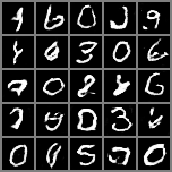

epoch: 3/300, batch: 510/600, G_loss: 2.5811824798583984, D_loss: (0.7327899932861328, 0.10334305465221405, 0.39948925375938416)
epoch: 3/300, batch: 520/600, G_loss: 2.6143057346343994, D_loss: (0.7578107714653015, 0.10220570862293243, 0.37965309619903564)
epoch: 3/300, batch: 530/600, G_loss: 3.3294451236724854, D_loss: (0.9424062967300415, 0.04599595069885254, 0.30372244119644165)
epoch: 3/300, batch: 540/600, G_loss: 2.500364303588867, D_loss: (0.6903901100158691, 0.10495438426733017, 0.4212329387664795)
epoch: 3/300, batch: 550/600, G_loss: 3.0756967067718506, D_loss: (1.1281781196594238, 0.06201180815696716, 0.23797906935214996)
epoch: 3/300, batch: 560/600, G_loss: 2.575988531112671, D_loss: (0.8296217918395996, 0.10774445533752441, 0.35447683930397034)
epoch: 3/300, batch: 570/600, G_loss: 1.6699138879776, D_loss: (0.41229248046875, 0.25619298219680786, 0.696938157081604)
epoch: 3/300, batch: 580/600, G_loss: 2.3399581909179688, D_loss: (0.6852441430091858, 0.12863470613956451,

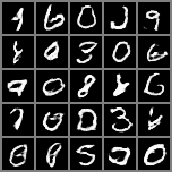

epoch: 4/300, batch: 10/600, G_loss: 2.1952080726623535, D_loss: (0.5020923614501953, 0.15214179456233978, 0.5102860927581787)
epoch: 4/300, batch: 20/600, G_loss: 2.432851791381836, D_loss: (0.5353083610534668, 0.12631173431873322, 0.5273224115371704)
epoch: 4/300, batch: 30/600, G_loss: 2.019564628601074, D_loss: (0.45214030146598816, 0.17897140979766846, 0.5930947661399841)
epoch: 4/300, batch: 40/600, G_loss: 1.856600284576416, D_loss: (0.4555589258670807, 0.215140700340271, 0.5743319392204285)
epoch: 4/300, batch: 50/600, G_loss: 1.3590762615203857, D_loss: (0.3315980136394501, 0.36259278655052185, 0.7980520725250244)
epoch: 4/300, batch: 60/600, G_loss: 2.530362129211426, D_loss: (0.514424741268158, 0.1132441982626915, 0.510191023349762)
epoch: 4/300, batch: 70/600, G_loss: 2.643880844116211, D_loss: (0.7997365593910217, 0.09425559639930725, 0.30411869287490845)
epoch: 4/300, batch: 80/600, G_loss: 3.1907870769500732, D_loss: (0.7961328625679016, 0.058320075273513794, 0.292517334

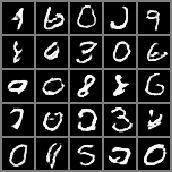

epoch: 4/300, batch: 110/600, G_loss: 1.2336136102676392, D_loss: (0.38483577966690063, 0.43591204285621643, 0.6620725393295288)
epoch: 4/300, batch: 120/600, G_loss: 1.211881399154663, D_loss: (0.867035448551178, 0.3710913062095642, 0.38900330662727356)
epoch: 4/300, batch: 130/600, G_loss: 1.4508508443832397, D_loss: (0.7891320586204529, 0.30976811051368713, 0.35499680042266846)
epoch: 4/300, batch: 140/600, G_loss: 1.5241878032684326, D_loss: (0.6914085149765015, 0.2876831889152527, 0.3569889962673187)
epoch: 4/300, batch: 150/600, G_loss: 1.4921799898147583, D_loss: (0.723995566368103, 0.29904502630233765, 0.3436475098133087)
epoch: 4/300, batch: 160/600, G_loss: 1.2586456537246704, D_loss: (0.6438886523246765, 0.38235244154930115, 0.3927977383136749)
epoch: 4/300, batch: 170/600, G_loss: 1.5197176933288574, D_loss: (0.6626631021499634, 0.29875648021698, 0.3654799163341522)
epoch: 4/300, batch: 180/600, G_loss: 1.5780513286590576, D_loss: (0.7232292294502258, 0.28103750944137573, 0

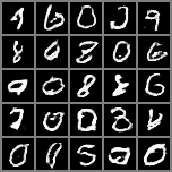

epoch: 4/300, batch: 210/600, G_loss: 1.7542824745178223, D_loss: (0.6727640628814697, 0.22796568274497986, 0.3276878297328949)
epoch: 4/300, batch: 220/600, G_loss: 1.7062126398086548, D_loss: (0.6528448462486267, 0.25176072120666504, 0.3857131600379944)
epoch: 4/300, batch: 230/600, G_loss: 1.9913579225540161, D_loss: (0.7658914923667908, 0.1732914000749588, 0.28189989924430847)
epoch: 4/300, batch: 240/600, G_loss: 1.3870666027069092, D_loss: (0.4584856331348419, 0.3580184578895569, 0.47283414006233215)
epoch: 4/300, batch: 250/600, G_loss: 1.8866407871246338, D_loss: (0.6861333250999451, 0.2112860083580017, 0.33507251739501953)
epoch: 4/300, batch: 260/600, G_loss: 1.9497556686401367, D_loss: (0.6334444284439087, 0.20960254967212677, 0.36480194330215454)
epoch: 4/300, batch: 270/600, G_loss: 1.8763688802719116, D_loss: (0.6657840609550476, 0.20230931043624878, 0.3346650302410126)
epoch: 4/300, batch: 280/600, G_loss: 2.0602712631225586, D_loss: (0.7416728138923645, 0.17239931225776

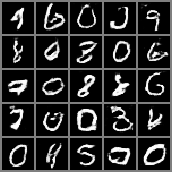

epoch: 4/300, batch: 310/600, G_loss: 2.3444626331329346, D_loss: (0.7075372934341431, 0.13521508872509003, 0.2762095332145691)
epoch: 4/300, batch: 320/600, G_loss: 2.347379684448242, D_loss: (0.9096047878265381, 0.14352282881736755, 0.23494508862495422)
epoch: 4/300, batch: 330/600, G_loss: 2.0957508087158203, D_loss: (0.6029309034347534, 0.1636030524969101, 0.315443754196167)
epoch: 4/300, batch: 340/600, G_loss: 2.0674362182617188, D_loss: (0.5540874600410461, 0.18450868129730225, 0.32551565766334534)
epoch: 4/300, batch: 350/600, G_loss: 2.2971560955047607, D_loss: (0.6343827247619629, 0.1432132124900818, 0.28755074739456177)
epoch: 4/300, batch: 360/600, G_loss: 1.8651105165481567, D_loss: (0.5172272324562073, 0.233613982796669, 0.40510451793670654)
epoch: 4/300, batch: 370/600, G_loss: 2.0348899364471436, D_loss: (0.6428070664405823, 0.193619042634964, 0.2959991693496704)
epoch: 4/300, batch: 380/600, G_loss: 1.3511182069778442, D_loss: (0.31990593671798706, 0.38373908400535583,

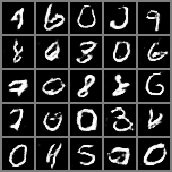

epoch: 4/300, batch: 410/600, G_loss: 1.3567018508911133, D_loss: (0.40386661887168884, 0.3911125659942627, 0.5465162992477417)
epoch: 4/300, batch: 420/600, G_loss: 2.151289224624634, D_loss: (0.6807661652565002, 0.1682639718055725, 0.31278711557388306)
epoch: 4/300, batch: 430/600, G_loss: 1.8024786710739136, D_loss: (0.5046407580375671, 0.25895339250564575, 0.39598792791366577)
epoch: 4/300, batch: 440/600, G_loss: 2.1800942420959473, D_loss: (0.5877647995948792, 0.1668175756931305, 0.30277693271636963)
epoch: 4/300, batch: 450/600, G_loss: 2.181302070617676, D_loss: (0.6163453459739685, 0.17587286233901978, 0.2896243631839752)
epoch: 4/300, batch: 460/600, G_loss: 1.4456580877304077, D_loss: (0.3284348249435425, 0.3619864284992218, 0.5101139545440674)
epoch: 4/300, batch: 470/600, G_loss: 1.831504464149475, D_loss: (0.47030574083328247, 0.24290890991687775, 0.4079592525959015)
epoch: 4/300, batch: 480/600, G_loss: 2.1746468544006348, D_loss: (0.5155548453330994, 0.17127934098243713

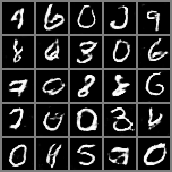

epoch: 4/300, batch: 510/600, G_loss: 2.2304441928863525, D_loss: (0.5235791206359863, 0.16240772604942322, 0.3541181683540344)
epoch: 4/300, batch: 520/600, G_loss: 2.460465431213379, D_loss: (0.7874230742454529, 0.1382600963115692, 0.23370972275733948)
epoch: 4/300, batch: 530/600, G_loss: 3.0671908855438232, D_loss: (0.8681567907333374, 0.0682358667254448, 0.17778678238391876)
epoch: 4/300, batch: 540/600, G_loss: 2.355823040008545, D_loss: (0.6898431181907654, 0.1498754918575287, 0.24763800203800201)
epoch: 4/300, batch: 550/600, G_loss: 2.2966055870056152, D_loss: (0.5055246949195862, 0.15323998034000397, 0.3143663704395294)
epoch: 4/300, batch: 560/600, G_loss: 1.761324405670166, D_loss: (0.4600023925304413, 0.2885023057460785, 0.39573249220848083)
epoch: 4/300, batch: 570/600, G_loss: 1.9676661491394043, D_loss: (0.4199845790863037, 0.2055504024028778, 0.40669527649879456)
epoch: 4/300, batch: 580/600, G_loss: 2.0099666118621826, D_loss: (0.39521393179893494, 0.21316562592983246

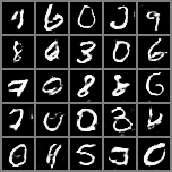

epoch: 5/300, batch: 10/600, G_loss: 1.809982419013977, D_loss: (0.3711124658584595, 0.2670895457267761, 0.4485519528388977)
epoch: 5/300, batch: 20/600, G_loss: 2.56760311126709, D_loss: (0.5417047739028931, 0.12433256953954697, 0.2921741306781769)
epoch: 5/300, batch: 30/600, G_loss: 2.4948601722717285, D_loss: (0.5110841989517212, 0.1318853348493576, 0.2820884585380554)
epoch: 5/300, batch: 40/600, G_loss: 2.0908589363098145, D_loss: (0.540932297706604, 0.19951200485229492, 0.30324888229370117)
epoch: 5/300, batch: 50/600, G_loss: 2.4624762535095215, D_loss: (0.4702516496181488, 0.13426543772220612, 0.31966108083724976)
epoch: 5/300, batch: 60/600, G_loss: 2.9036262035369873, D_loss: (0.5942552089691162, 0.09137623012065887, 0.23871123790740967)
epoch: 5/300, batch: 70/600, G_loss: 1.860293984413147, D_loss: (0.3917728364467621, 0.24189096689224243, 0.34539225697517395)
epoch: 5/300, batch: 80/600, G_loss: 2.3838703632354736, D_loss: (0.4631536602973938, 0.1336459517478943, 0.348385

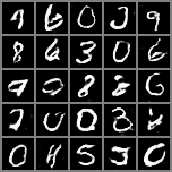

epoch: 5/300, batch: 110/600, G_loss: 2.6277785301208496, D_loss: (0.4316782057285309, 0.1165531724691391, 0.31380465626716614)
epoch: 5/300, batch: 120/600, G_loss: 3.1843292713165283, D_loss: (0.5135324597358704, 0.07248528301715851, 0.2605283856391907)
epoch: 5/300, batch: 130/600, G_loss: 2.698903799057007, D_loss: (0.48366522789001465, 0.10027625411748886, 0.28292611241340637)
epoch: 5/300, batch: 140/600, G_loss: 1.865360975265503, D_loss: (0.2299710065126419, 0.2546224296092987, 0.5074213743209839)
epoch: 5/300, batch: 150/600, G_loss: 1.2516558170318604, D_loss: (0.19065357744693756, 0.472662091255188, 0.68916916847229)
epoch: 5/300, batch: 160/600, G_loss: 2.350148916244507, D_loss: (0.4777317941188812, 0.1549326479434967, 0.2662894129753113)
epoch: 5/300, batch: 170/600, G_loss: 2.7073638439178467, D_loss: (0.44348466396331787, 0.09955175220966339, 0.29400214552879333)
epoch: 5/300, batch: 180/600, G_loss: 2.492720127105713, D_loss: (0.5883078575134277, 0.14057928323745728, 0

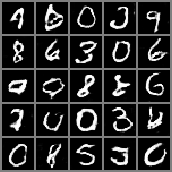

epoch: 5/300, batch: 210/600, G_loss: 2.923638343811035, D_loss: (0.5577067732810974, 0.09873959422111511, 0.21586376428604126)
epoch: 5/300, batch: 220/600, G_loss: 2.839707612991333, D_loss: (0.4252687394618988, 0.09341804683208466, 0.2592187821865082)
epoch: 5/300, batch: 230/600, G_loss: 2.652982711791992, D_loss: (0.42963454127311707, 0.1209326907992363, 0.2810359597206116)
epoch: 5/300, batch: 240/600, G_loss: 2.791884660720825, D_loss: (0.5502853393554688, 0.12067751586437225, 0.24759933352470398)
epoch: 5/300, batch: 250/600, G_loss: 2.6209604740142822, D_loss: (0.504250705242157, 0.1316993683576584, 0.26989543437957764)
epoch: 5/300, batch: 260/600, G_loss: 2.3545045852661133, D_loss: (0.3177063465118408, 0.18973812460899353, 0.3241228759288788)
epoch: 5/300, batch: 270/600, G_loss: 1.7846789360046387, D_loss: (0.19943591952323914, 0.26949450373649597, 0.5933612585067749)
epoch: 5/300, batch: 280/600, G_loss: 1.840242862701416, D_loss: (0.2879137098789215, 0.26771578192710876,

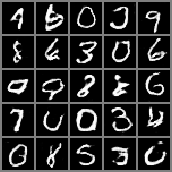

epoch: 5/300, batch: 310/600, G_loss: 2.625575542449951, D_loss: (0.7103949785232544, 0.1282188445329666, 0.18335065245628357)
epoch: 5/300, batch: 320/600, G_loss: 2.6973049640655518, D_loss: (0.3153686821460724, 0.12302803248167038, 0.3838602304458618)
epoch: 5/300, batch: 330/600, G_loss: 2.4393270015716553, D_loss: (0.4728020131587982, 0.14559917151927948, 0.2667708396911621)
epoch: 5/300, batch: 340/600, G_loss: 2.9798572063446045, D_loss: (0.6443904638290405, 0.08643092960119247, 0.20439085364341736)
epoch: 5/300, batch: 350/600, G_loss: 1.4250015020370483, D_loss: (0.2169419527053833, 0.43729835748672485, 0.5382324457168579)
epoch: 5/300, batch: 360/600, G_loss: 2.3550055027008057, D_loss: (0.4428650140762329, 0.17133605480194092, 0.22447706758975983)
epoch: 5/300, batch: 370/600, G_loss: 3.0353946685791016, D_loss: (0.4232408106327057, 0.09558435529470444, 0.26489710807800293)
epoch: 5/300, batch: 380/600, G_loss: 2.968069553375244, D_loss: (0.4628491997718811, 0.08968028426170

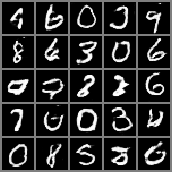

epoch: 5/300, batch: 410/600, G_loss: 2.9800796508789062, D_loss: (0.6617290377616882, 0.09488248080015182, 0.1370382010936737)
epoch: 5/300, batch: 420/600, G_loss: 2.8931493759155273, D_loss: (0.6223031878471375, 0.10322482883930206, 0.19712890684604645)
epoch: 5/300, batch: 430/600, G_loss: 2.5255844593048096, D_loss: (0.3437120318412781, 0.14790216088294983, 0.3305552005767822)
epoch: 5/300, batch: 440/600, G_loss: 3.140014886856079, D_loss: (0.5164951086044312, 0.07411959767341614, 0.21141810715198517)
epoch: 5/300, batch: 450/600, G_loss: 2.9802496433258057, D_loss: (0.40999504923820496, 0.09350081533193588, 0.24051660299301147)
epoch: 5/300, batch: 460/600, G_loss: 2.675002336502075, D_loss: (0.6127286553382874, 0.1301468312740326, 0.15085469186306)
epoch: 5/300, batch: 470/600, G_loss: 1.4521678686141968, D_loss: (0.2267930954694748, 0.44759324193000793, 0.4797727167606354)
epoch: 5/300, batch: 480/600, G_loss: 2.8158812522888184, D_loss: (0.5114429593086243, 0.0936597287654876

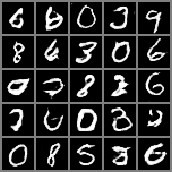

epoch: 5/300, batch: 510/600, G_loss: 2.442251682281494, D_loss: (0.4706045389175415, 0.14941094815731049, 0.19174237549304962)
epoch: 5/300, batch: 520/600, G_loss: 3.1157028675079346, D_loss: (0.46179771423339844, 0.08536772429943085, 0.1803501695394516)
epoch: 5/300, batch: 530/600, G_loss: 1.9916633367538452, D_loss: (0.4559594690799713, 0.2700367271900177, 0.1871694028377533)
epoch: 5/300, batch: 540/600, G_loss: 2.689162254333496, D_loss: (0.5530096888542175, 0.11693757772445679, 0.19686686992645264)
epoch: 5/300, batch: 550/600, G_loss: 2.4919004440307617, D_loss: (0.4252758324146271, 0.14853233098983765, 0.23353302478790283)
epoch: 5/300, batch: 560/600, G_loss: 2.418851852416992, D_loss: (0.30807217955589294, 0.1687341332435608, 0.25408828258514404)
epoch: 5/300, batch: 570/600, G_loss: 3.239121437072754, D_loss: (0.5582653284072876, 0.07279552519321442, 0.14015419781208038)
epoch: 5/300, batch: 580/600, G_loss: 3.2275238037109375, D_loss: (0.48378846049308777, 0.0689531490206

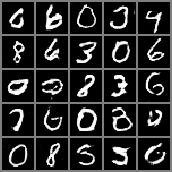

epoch: 6/300, batch: 10/600, G_loss: 2.720548152923584, D_loss: (0.5637713074684143, 0.13972559571266174, 0.13321787118911743)
epoch: 6/300, batch: 20/600, G_loss: 2.9585890769958496, D_loss: (0.3030546307563782, 0.09648128598928452, 0.20596656203269958)
epoch: 6/300, batch: 30/600, G_loss: 3.1656811237335205, D_loss: (0.4921703338623047, 0.08047465234994888, 0.17473576962947845)
epoch: 6/300, batch: 40/600, G_loss: 3.5937743186950684, D_loss: (1.205422043800354, 0.06058114022016525, 0.06804125756025314)
epoch: 6/300, batch: 50/600, G_loss: 2.1304173469543457, D_loss: (0.526679515838623, 0.22594356536865234, 0.16966824233531952)
epoch: 6/300, batch: 60/600, G_loss: 2.5678536891937256, D_loss: (0.4025089144706726, 0.15085835754871368, 0.20932939648628235)
epoch: 6/300, batch: 70/600, G_loss: 3.198441505432129, D_loss: (0.5911300182342529, 0.07072315365076065, 0.17208240926265717)
epoch: 6/300, batch: 80/600, G_loss: 2.4259791374206543, D_loss: (0.29502156376838684, 0.15276473760604858, 

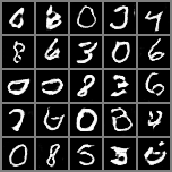

epoch: 6/300, batch: 110/600, G_loss: 3.117922306060791, D_loss: (0.5934492349624634, 0.09372363984584808, 0.15084584057331085)
epoch: 6/300, batch: 120/600, G_loss: 3.6456754207611084, D_loss: (0.5974742770195007, 0.05157831311225891, 0.1234235167503357)
epoch: 6/300, batch: 130/600, G_loss: 3.4917562007904053, D_loss: (0.48584896326065063, 0.05873095989227295, 0.16433735191822052)
epoch: 6/300, batch: 140/600, G_loss: 2.207887887954712, D_loss: (0.30681151151657104, 0.2170374095439911, 0.27303969860076904)
epoch: 6/300, batch: 150/600, G_loss: 2.8680176734924316, D_loss: (0.5659485459327698, 0.11274880170822144, 0.11854291707277298)
epoch: 6/300, batch: 160/600, G_loss: 3.089076519012451, D_loss: (0.5731462240219116, 0.08700455725193024, 0.13918755948543549)
epoch: 6/300, batch: 170/600, G_loss: 2.3763437271118164, D_loss: (0.5611234903335571, 0.20961372554302216, 0.17760786414146423)
epoch: 6/300, batch: 180/600, G_loss: 2.0704903602600098, D_loss: (0.5043503046035767, 0.24463321268

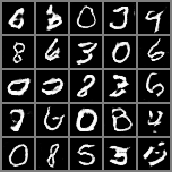

epoch: 6/300, batch: 210/600, G_loss: 1.3451287746429443, D_loss: (0.1469348520040512, 0.48996502161026, 0.5384761691093445)
epoch: 6/300, batch: 220/600, G_loss: 3.2237465381622314, D_loss: (0.4511781334877014, 0.0878763496875763, 0.15313294529914856)
epoch: 6/300, batch: 230/600, G_loss: 2.767082452774048, D_loss: (0.4536997079849243, 0.13302624225616455, 0.13840924203395844)
epoch: 6/300, batch: 240/600, G_loss: 1.7992470264434814, D_loss: (0.24226367473602295, 0.34188613295555115, 0.2659750282764435)
epoch: 6/300, batch: 250/600, G_loss: 3.5859458446502686, D_loss: (0.4913046658039093, 0.06025538593530655, 0.17024163901805878)
epoch: 6/300, batch: 260/600, G_loss: 3.4521634578704834, D_loss: (0.6024138927459717, 0.054526057094335556, 0.13274738192558289)
epoch: 6/300, batch: 270/600, G_loss: 1.954840064048767, D_loss: (0.2335864007472992, 0.26574844121932983, 0.2997540831565857)
epoch: 6/300, batch: 280/600, G_loss: 1.7004518508911133, D_loss: (0.1878623366355896, 0.349404513835907

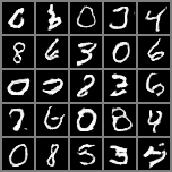

epoch: 6/300, batch: 310/600, G_loss: 2.617539405822754, D_loss: (0.4375685155391693, 0.1720588058233261, 0.13625578582286835)
epoch: 6/300, batch: 320/600, G_loss: 2.5404512882232666, D_loss: (0.29308730363845825, 0.16155149042606354, 0.18448469042778015)
epoch: 6/300, batch: 330/600, G_loss: 2.3259363174438477, D_loss: (0.25129809975624084, 0.20050491392612457, 0.2969973087310791)
epoch: 6/300, batch: 340/600, G_loss: 3.1600093841552734, D_loss: (0.4534136950969696, 0.08620785921812057, 0.1459285318851471)
epoch: 6/300, batch: 350/600, G_loss: 2.9968678951263428, D_loss: (0.5546057224273682, 0.111191026866436, 0.13625119626522064)
epoch: 6/300, batch: 360/600, G_loss: 2.930532217025757, D_loss: (0.50677889585495, 0.1066170334815979, 0.13268347084522247)
epoch: 6/300, batch: 370/600, G_loss: 2.526050329208374, D_loss: (0.3727404475212097, 0.16499580442905426, 0.18353310227394104)
epoch: 6/300, batch: 380/600, G_loss: 3.287773847579956, D_loss: (1.0142707824707031, 0.08183130621910095,

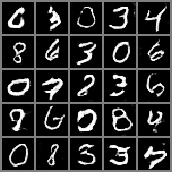

epoch: 6/300, batch: 410/600, G_loss: 2.9068942070007324, D_loss: (0.3833388090133667, 0.10808594524860382, 0.15577073395252228)
epoch: 6/300, batch: 420/600, G_loss: 1.8836404085159302, D_loss: (0.2624060809612274, 0.28023669123649597, 0.2743670344352722)
epoch: 6/300, batch: 430/600, G_loss: 2.3278286457061768, D_loss: (0.22560642659664154, 0.198226198554039, 0.25896742939949036)
epoch: 6/300, batch: 440/600, G_loss: 1.8077908754348755, D_loss: (0.3862757086753845, 0.31081289052963257, 0.16386495530605316)
epoch: 6/300, batch: 450/600, G_loss: 1.7285560369491577, D_loss: (0.3597804307937622, 0.34850943088531494, 0.16533035039901733)


In [0]:
for epoch in range(num_epochs):

    # Train epoch
    for n_batch, (real_samples,real_labels) in enumerate(data_loader):
        
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
        real_labels = Variable(real_labels).float().cuda()
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, id_to_onehot(real_labels))
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 100 == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val, lab=labs_val)[0].data.cpu()
            display_batch_images(val_fake_samples)

In [51]:
labs_val2 = torch.zeros(25, 10)
for i in range(25):
    labs_val2[i, 8] = 1.0
labs_val2 = labs_val2.cuda()

val_fake_samples = model.generate_samples(num_val_samples, z=norm_noise(25), lab=labs_val2)[0].data.cpu()
display_batch_images(val_fake_samples)


NameError: ignored